# Business Problem

The goal is to predict whether a credit card application will be approved based on the applicant's demographic, financial, and employment data. This will help financial institutions assess the risk associated with a potential customer, reducing defaults and increasing the efficiency of the approval process.

# Load Data

In [68]:
# Step 1: Import libraries
import pandas as pd
import numpy as np

# Step 2: Load datasets
application_df = pd.read_csv('application_record.csv')
credit_df = pd.read_csv('credit_record.csv')

In [2]:
application_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [3]:
credit_df.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


# Data Preprocessing

In [4]:
# Step 3: Preprocess credit history data

#Simplify the STATUS column
credit_df['STATUS'] = credit_df['STATUS'].apply(lambda x: 'Bad Debt' if x in ['1','2', '3', '4', '5'] else 'Good Debt')

#Calculate counts of Bad Debt and Good Debt for each applicant
credit_summary = credit_df.groupby('ID')['STATUS'].value_counts().unstack(fill_value=0)

# Calculate the ratio of Bad Debt to Good Debt
credit_summary['Bad Debt Ratio'] = credit_summary['Bad Debt'] / (credit_summary['Good Debt'] + 1)  # Add 1 to avoid division by zero

# Adjust the target based on the ratio: 
# If the Bad Debt Ratio is less than 0.15 (15%), the customer is eligible (Target = 1), otherwise not eligible (Target = 0)
credit_summary['Target'] = credit_summary.apply(lambda x: 0 if x['Bad Debt Ratio'] >= 0.15 else 1, axis=1)

# Step 4: Merge the credit summary with the application data
data = application_df.merge(credit_summary, on='ID', how='inner')

In [5]:
# Rename columns
data.rename(columns={
    'CODE_GENDER': 'GENDER',
    'FLAG_OWN_CAR': 'OWN_CAR',
    'FLAG_OWN_REALTY': 'OWN_REALTY',
    'NAME_INCOME_TYPE': 'INCOME_TYPE',
    'NAME_EDUCATION_TYPE': 'EDUCATION_TYPE',
    'NAME_FAMILY_STATUS': 'FAMILY_STATUS',
    'NAME_HOUSING_TYPE': 'HOUSING_TYPE',
    'FLAG_MOBIL': 'MOBIL',
    'FLAG_WORK_PHONE': 'WORK_PHONE',
    'FLAG_PHONE': 'PHONE',
    'FLAG_EMAIL': 'EMAIL'
}, inplace=True)

data.head()

,ID,GENDER,OWN_CAR,OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,INCOME_TYPE,EDUCATION_TYPE,FAMILY_STATUS,HOUSING_TYPE,...,MOBIL,WORK_PHONE,PHONE,EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,Bad Debt,Good Debt,Bad Debt Ratio,Target
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,1,0,0,NaN,2.0,1,15,0.062500,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,1,0,0,NaN,2.0,1,14,0.066667,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,1,0,0,0,Security staff,2.0,0,30,0.000000,1
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1,0,1,1,Sales staff,1.0,0,5,0.000000,1
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1,0,1,1,Sales staff,1.0,0,5,0.000000,1


# Exploratory Data Analysis

In [6]:
#Get resulted data shape

data.shape

(36457, 22)

In [7]:
#Data Types: Check the data types of each column to ensure correct types.
data.dtypes

ID                    int64
GENDER               object
OWN_CAR              object
OWN_REALTY           object
CNT_CHILDREN          int64
AMT_INCOME_TOTAL    float64
INCOME_TYPE          object
EDUCATION_TYPE       object
FAMILY_STATUS        object
HOUSING_TYPE         object
DAYS_BIRTH            int64
DAYS_EMPLOYED         int64
MOBIL                 int64
WORK_PHONE            int64
PHONE                 int64
EMAIL                 int64
OCCUPATION_TYPE      object
CNT_FAM_MEMBERS     float64
Bad Debt              int64
Good Debt             int64
Bad Debt Ratio      float64
Target                int64
dtype: object

In [8]:
# Identify categorical columns and count unique values
categorical_columns = data.select_dtypes(include='object')  # Select categorical columns

# Print the number of unique values and the unique values for each categorical column
for column in categorical_columns.columns:
    print(f"Column: {column}")
    print(f"Number of Unique Values: {categorical_columns[column].nunique()}")
    print(f"Unique Values: {categorical_columns[column].unique()}\n")

Column: GENDER
Number of Unique Values: 2
Unique Values: ['M' 'F']

Column: OWN_CAR
Number of Unique Values: 2
Unique Values: ['Y' 'N']

Column: OWN_REALTY
Number of Unique Values: 2
Unique Values: ['Y' 'N']

Column: INCOME_TYPE
Number of Unique Values: 5
Unique Values: ['Working' 'Commercial associate' 'Pensioner' 'State servant' 'Student']

Column: EDUCATION_TYPE
Number of Unique Values: 5
Unique Values: ['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']

Column: FAMILY_STATUS
Number of Unique Values: 5
Unique Values: ['Civil marriage' 'Married' 'Single / not married' 'Separated' 'Widow']

Column: HOUSING_TYPE
Number of Unique Values: 6
Unique Values: ['Rented apartment' 'House / apartment' 'Municipal apartment'
 'With parents' 'Co-op apartment' 'Office apartment']

Column: OCCUPATION_TYPE
Number of Unique Values: 18
Unique Values: [nan 'Security staff' 'Sales staff' 'Accountants' 'Laborers' 'Managers'
 'Drivers' 'Core staff'

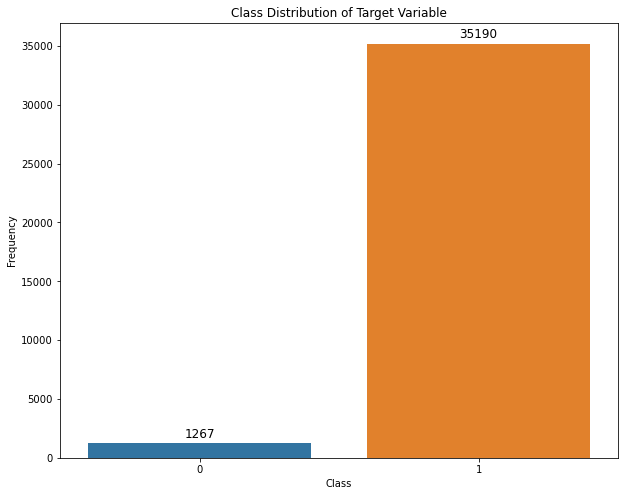

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the class distribution using seaborn
plt.figure(figsize=(10, 8))
ax = sns.countplot(x='Target', data=data)  # Make sure to reference 'Target' from 'data'

# Add annotations
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 9), textcoords='offset points')

plt.title('Class Distribution of Target Variable')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

**Insight:**
    The bar chart reveals a significant imbalance in the dataset. There are two classes:

**Class 0:** Frequency of 1,267

**Class 1:** Frequency of 35,190

This indicates that class 1 is much more prevalent than class 0, suggesting a highly imbalanced dataset. Such imbalance can impact the performance of machine learning models, requiring techniques like resampling or weighting to address this issue for more accurate results.

In [10]:
# Check for duplicates in the dataset
duplicates = data.duplicated().sum()

# Print result
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


In [11]:
# Check the number of missing values in each column
missing_values = data.isnull().sum()

# Print result
print("Number of missing values in each column:")
print(missing_values)

Number of missing values in each column:
ID                      0
GENDER                  0
OWN_CAR                 0
OWN_REALTY              0
CNT_CHILDREN            0
AMT_INCOME_TOTAL        0
INCOME_TYPE             0
EDUCATION_TYPE          0
FAMILY_STATUS           0
HOUSING_TYPE            0
DAYS_BIRTH              0
DAYS_EMPLOYED           0
MOBIL                   0
WORK_PHONE              0
PHONE                   0
EMAIL                   0
OCCUPATION_TYPE     11323
CNT_FAM_MEMBERS         0
Bad Debt                0
Good Debt               0
Bad Debt Ratio          0
Target                  0
dtype: int64


In [12]:
# Convert DAYS_BIRTH to age in years
data['AGE_YEARS'] = (-data['DAYS_BIRTH']) // 365

#Convert DAYS_EMPLOYED to Positive:
data['DAYS_EMPLOYED'] = abs(data['DAYS_EMPLOYED'])

# Handle missing values (for simplicity, fill with 'Unknown')
data.fillna('Unknown', inplace=True)

In [13]:
# Drop unnecessary columns
data = data.drop(columns=['ID','DAYS_BIRTH','Bad Debt Ratio','Bad Debt','Good Debt'])  

In [14]:
#Summary Statistics: Get basic statistics for numerical columns

data.describe()

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_EMPLOYED,MOBIL,WORK_PHONE,PHONE,EMAIL,CNT_FAM_MEMBERS,Target,AGE_YEARS
count,36457.000000,3.645700e+04,36457.000000,36457.0,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000
mean,0.430315,1.866857e+05,63663.569904,1.0,0.225526,0.294813,0.089722,2.198453,0.965247,43.260334
std,0.742367,1.017892e+05,135672.106747,0.0,0.417934,0.455965,0.285787,0.911686,0.183157,11.510414
min,0.000000,2.700000e+04,17.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,20.000000
25%,0.000000,1.215000e+05,1169.000000,1.0,0.000000,0.000000,0.000000,2.000000,1.000000,34.000000
50%,0.000000,1.575000e+05,2518.000000,1.0,0.000000,0.000000,0.000000,2.000000,1.000000,42.000000
75%,1.000000,2.250000e+05,5679.000000,1.0,0.000000,1.000000,0.000000,3.000000,1.000000,53.000000
max,19.000000,1.575000e+06,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,1.000000,68.000000


### Univariate Analysis

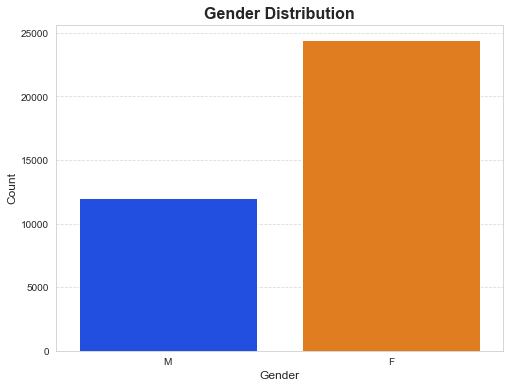

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style and bright color palette
sns.set_style("whitegrid")
sns.set_palette("bright")

# Plot Gender Distribution using Seaborn
plt.figure(figsize=(8, 6))
sns.countplot(x='GENDER', data=data, palette='bright')

# Add labels, title, and grid
plt.title('Gender Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

**Insight:**

The bar chart shows a clear difference in the count of two gender categories. The count for "M" (male) is around 12,500, while the count for "F" (female) is about 25,000. This indicates that there are significantly more females than males in this dataset.

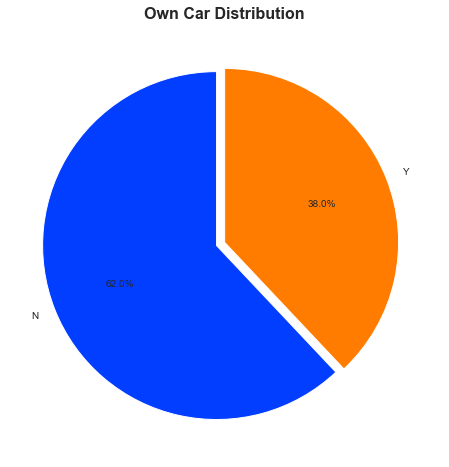

In [16]:
# Set Seaborn style for consistency
sns.set_style("whitegrid")

# Get value counts for 'OWN_CAR'
car_distribution = data['OWN_CAR'].value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(car_distribution, 
        labels=car_distribution.index, 
        autopct='%1.1f%%', 
        colors=sns.color_palette('bright'), 
        startangle=90, 
        explode=(0.05, 0))  # Add explosion effect for better visualization

# Add title
plt.title('Own Car Distribution', fontsize=16, fontweight='bold')

# Display the plot
plt.show()


**Insight**

The pie chart shows that 62% of people do not own a car, while 38% do. This indicates that a larger portion of the population in this dataset does not own a car.

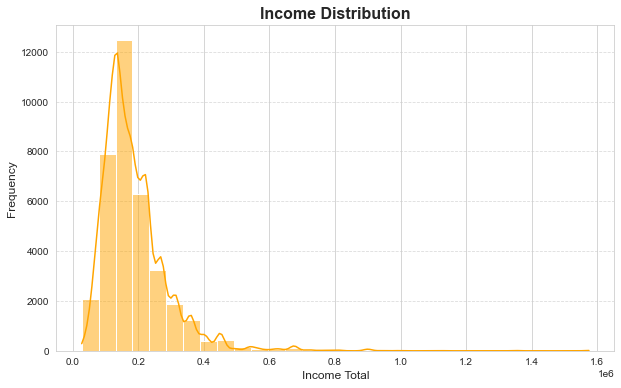

In [17]:
# Set Seaborn style and color palette
sns.set_style("whitegrid")
sns.set_palette("bright")

# Plot Income Distribution with KDE (Kernel Density Estimate)
plt.figure(figsize=(10, 6))
sns.histplot(data['AMT_INCOME_TOTAL'], kde=True, color='orange', bins=30)

# Add labels, title, and grid
plt.title('Income Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Income Total', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

**Insight:**

The histogram reveals that the majority of total income is concentrated at the lower end of the scale, peaking around 0.2 million. It indicates a right-skewed distribution with significantly fewer individuals having higher incomes, highlighting income inequality.

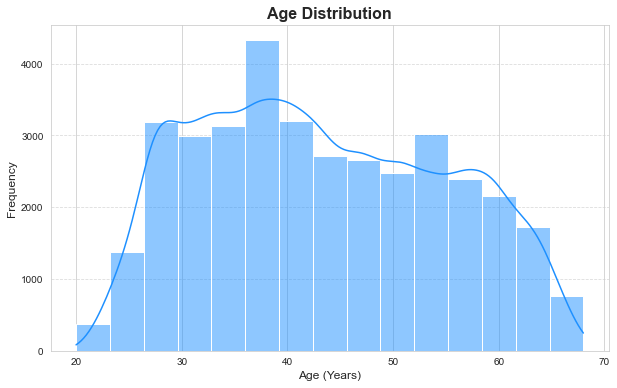

In [18]:
# Set Seaborn style and color palette
sns.set_style("whitegrid")
sns.set_palette("bright")

# Plot Age Distribution with KDE (Kernel Density Estimate)
plt.figure(figsize=(10, 6))
sns.histplot(data['AGE_YEARS'], kde=True, color='dodgerblue', bins=15)

# Add labels, title, and grid
plt.title('Age Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Age (Years)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

**Insight:**

The histogram shows that most of the population is concentrated between the ages of 30 and 50, with the peak frequency around age 40. This indicates a higher concentration of individuals in midlife within this dataset.

### Bivariate Analysis
Explore relationships between pairs of variables

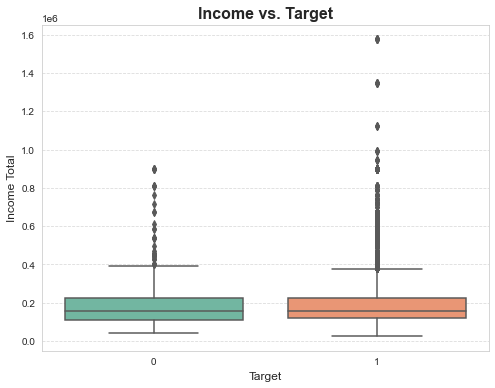

In [19]:
# Set Seaborn style and color palette
sns.set_style("whitegrid")
sns.set_palette("Set2")

# Plot Income vs. Target using a boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Target', y='AMT_INCOME_TOTAL', data=data, palette="Set2")

# Add labels, title, and grid
plt.title('Income vs. Target', fontsize=16, fontweight='bold')
plt.xlabel('Target', fontsize=12)
plt.ylabel('Income Total', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

**Insight:**

The box plot comparing "Income Total" against "Target" shows that both target categories have similar median incomes. However, there are more high-income outliers in the "Target" category 1, indicating a higher variability in income for this group. This is logical, as those with higher incomes are more likely to be able to pay off their debts, knowing that "0" represents not eligible for credit and "1" represents eligible.

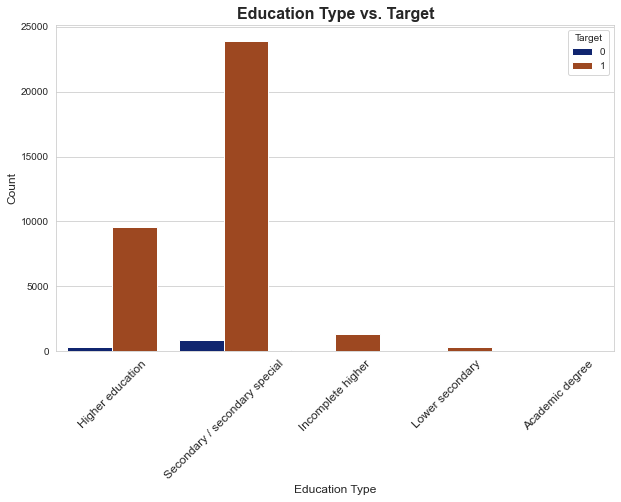

In [20]:
# Set Seaborn style and a high-contrast color palette
sns.set_style("whitegrid")
sns.set_palette("dark")

# Plot Education Type vs. Target using a countplot
plt.figure(figsize=(10, 6))
sns.countplot(x='EDUCATION_TYPE', hue='Target', data=data, palette="dark")

# Rotate x-axis labels for readability
plt.xticks(rotation=45, fontsize=12)

# Add title and labels
plt.title('Education Type vs. Target', fontsize=16, fontweight='bold')
plt.xlabel('Education Type', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.show()

**Insight:**
    The bar chart shows that most people in the dataset have "Secondary / secondary special" or "Higher education.

### Categorical vs. Numerical Features

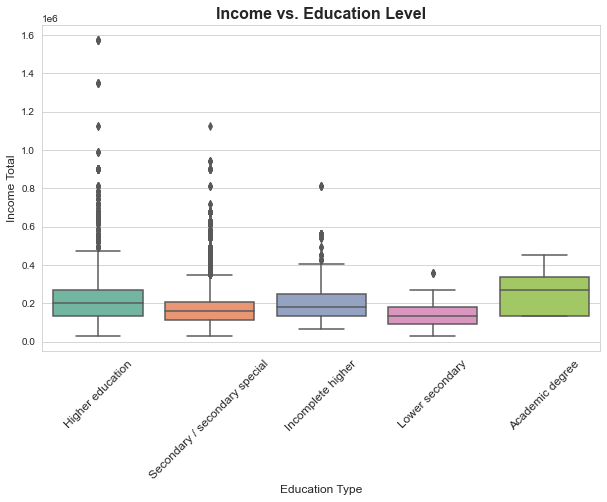

In [21]:
# Set Seaborn style and color palette
sns.set_style("whitegrid")
sns.set_palette("Set2")  # A distinct color palette for better clarity

# Plot Income vs. Education Level using a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='EDUCATION_TYPE', y='AMT_INCOME_TOTAL', data=data, palette="Set2")

# Rotate x-axis labels for readability
plt.xticks(rotation=45, fontsize=12)

# Add title and labels
plt.title('Income vs. Education Level', fontsize=16, fontweight='bold')
plt.xlabel('Education Type', fontsize=12)
plt.ylabel('Income Total', fontsize=12)

# Display the plot
plt.show()

**Insight:**

The box plot chart shows that higher education levels are associated with increased income. Specifically, individuals with Higher education and Academic degrees have higher median incomes compared to other education levels. This highlights the positive correlation between higher education and earning potential.

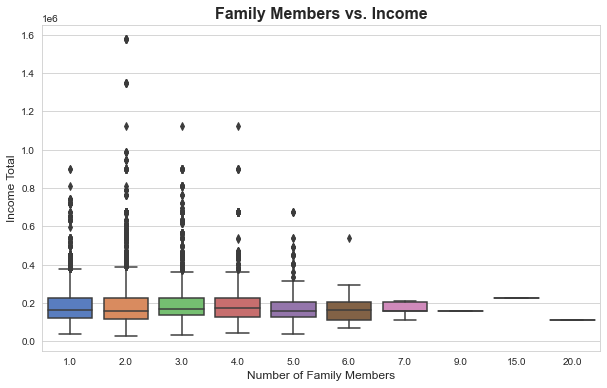

In [22]:
# Set Seaborn style and color palette
sns.set_style("whitegrid")
sns.set_palette("muted")  # A more subtle and modern color palette

# Plot Family Members vs. Income using a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='CNT_FAM_MEMBERS', y='AMT_INCOME_TOTAL', data=data, palette="muted")

# Add title and labels
plt.title('Family Members vs. Income', fontsize=16, fontweight='bold')
plt.xlabel('Number of Family Members', fontsize=12)
plt.ylabel('Income Total', fontsize=12)

# Display the plot
plt.show()

**Insight:**

As the number of family members increases, average income decreases. This trend may help classify applicants' credit eligibility, suggesting those with larger families might be less likely to get credit.

# Correlation Analysis

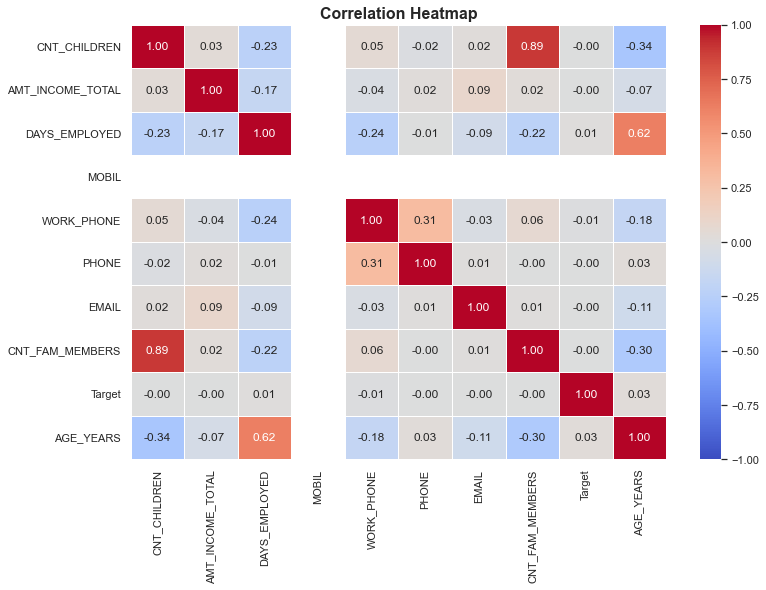

In [23]:
# Set Seaborn style for a clean background
sns.set(style="whitegrid")

# Calculate the correlation matrix
correlation_matrix = data.corr()

# Plot the heatmap with improved aesthetics
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)

# Add title
plt.title('Correlation Heatmap', fontsize=16, fontweight='bold')

# Display the plot
plt.show()

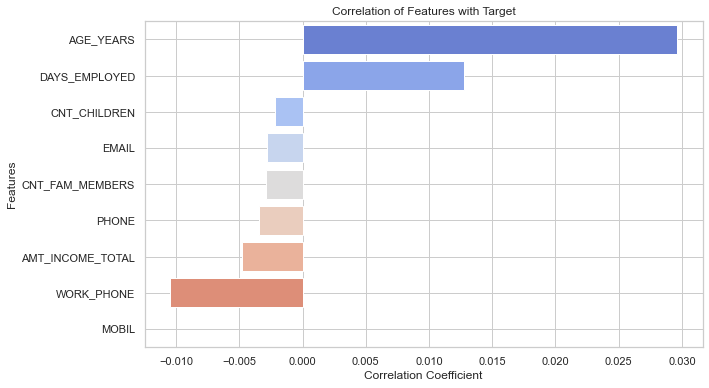

In [24]:
# Compute correlation matrix
corr_matrix = data.corr()

# Extract correlation with the target
target_corr = corr_matrix['Target'].drop('Target').sort_values(ascending=False)

# Plot the correlation
plt.figure(figsize=(10, 6))
sns.barplot(x=target_corr.values, y=target_corr.index, palette='coolwarm')
plt.title('Correlation of Features with Target')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.grid(True)
plt.show()

**Insight:**

The heatmap indicates variable correlations ranging from low to slightly high, with no correlation in the variable MOBIL. This suggests that the MOBIL variable should not be considered in the selected features for the machine learning model.


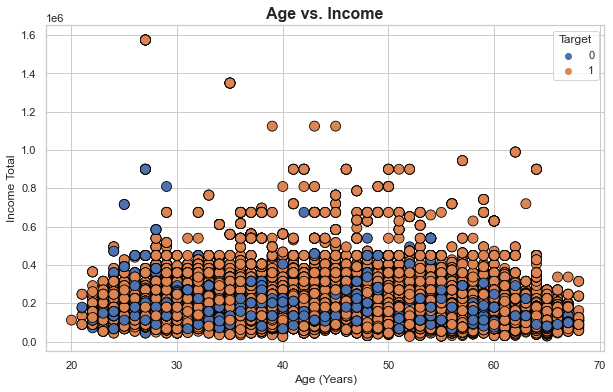

In [25]:
# Set Seaborn style and color palette
sns.set(style="whitegrid")
sns.set_palette("deep")  # A distinct, visually appealing color palette

# Plot Age vs. Income with a scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='AGE_YEARS', y='AMT_INCOME_TOTAL', hue='Target', data=data, palette="deep", s=100, edgecolor='black')

# Add title and labels
plt.title('Age vs. Income', fontsize=16, fontweight='bold')
plt.xlabel('Age (Years)', fontsize=12)
plt.ylabel('Income Total', fontsize=12)

# Display the plot
plt.show()

**Insight:**

The scatter plot titled "Age vs. Income" shows that income tends to increase with age until around 50 years, after which it stabilizes. The data points are categorized by target values, with target 1 (orange) indicating higher income consistency across ages compared to target 0 (blue). This plot helps analyze the relationship between age and income distribution across different target groups.


# Categorical Features Encoding

In [26]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Step 1: Prepare features (X) by dropping 'Target' and 'MOBIL'
X = data.drop(columns=['Target', 'MOBIL'])
y = data['Target']

# Step 2: Encode categorical features with OneHotEncoder
categorical_columns = X.select_dtypes(include=['object']).columns

# Create the OneHotEncoder transformer
encoder = OneHotEncoder(sparse_output=False, drop='first')  # sparse_output instead of sparse
column_transformer = ColumnTransformer(transformers=[('cat', encoder, categorical_columns)], 
                                       remainder='passthrough')  # Keep non-categorical columns as they are

# Apply the transformation to X
X_encoded = column_transformer.fit_transform(X)

In [27]:
#from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Data Resampling & Feature Scaling

In [28]:
# Step 3: Apply SMOTE to balance the dataset
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Step 5: Scale the features using StandardScaler after SMOTE and splitting
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Machine Learning Models Comparison

In [29]:
# Step 1: List of models to evaluate with cross-validation
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
}

# Step 2: Perform cross-validation and calculate accuracy for each model
cv_accuracies = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_accuracies[name] = scores.mean()

# Step 3: Sort results by cross-validation accuracy in descending order
sorted_cv_accuracies = sorted(cv_accuracies.items(), key=lambda x: x[1], reverse=True)

# Step 4: Print cross-validation accuracy for each model
print("Model Performance Based on Cross-Validation Accuracy:")
for model_name, cv_acc in sorted_cv_accuracies:
    print(f"{model_name}: Cross-Validation Accuracy = {cv_acc:.2f}")

# Step 5: Display the best model based on the highest cross-validation accuracy
best_model = sorted_cv_accuracies[0]
print(f"\nThe best model is: {best_model[0]} with Cross-Validation Accuracy = {best_model[1]:.4f}")

Model Performance Based on Cross-Validation Accuracy:
Random Forest: Cross-Validation Accuracy = 0.98
Extra Trees: Cross-Validation Accuracy = 0.98
CatBoost: Cross-Validation Accuracy = 0.97
XGBoost: Cross-Validation Accuracy = 0.97
Decision Tree: Cross-Validation Accuracy = 0.97
LightGBM: Cross-Validation Accuracy = 0.96

The best model is: Random Forest with Cross-Validation Accuracy = 0.9785


# Random Forest Model

In [30]:
# Step 6: Fit the best model on the training set and evaluate on the test set
best_model_instance = models['Random Forest']
best_model_instance.fit(X_train_scaled, y_train)
test_predictions = best_model_instance.predict(X_test_scaled)

# Step 7: Calculate and print the test accuracy
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"\nTest Accuracy of the best model ({'Random Forest'}): {test_accuracy:.4f}")


Test Accuracy of the best model (Random Forest): 0.9798


# Classification Report

In [60]:
from sklearn.metrics import classification_report

# Step 8: Generate and print the classification report
print("\nClassification Report:")
print(classification_report(y_test, test_predictions))


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      7021
           1       0.98      0.98      0.98      7055

    accuracy                           0.98     14076
   macro avg       0.98      0.98      0.98     14076
weighted avg       0.98      0.98      0.98     14076



# Confusion Matrix

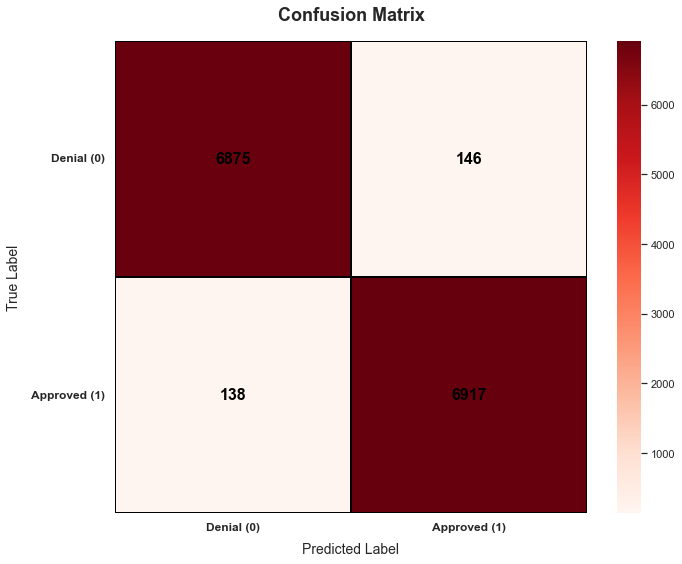

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Step 9: Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, test_predictions)

# Step 10: Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt='d', 
    cmap='Reds',  # Elegant color scheme
    annot_kws={"size": 16, "weight": "bold", "color": "black"},  # Bold annotations
    linewidths=2, 
    linecolor='black',
    square=True  # Makes the cells square-shaped
)

# Titles and labels with professional styling
plt.title('Confusion Matrix', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=14, labelpad=10)
plt.ylabel('True Label', fontsize=14, labelpad=10)

# Update class labels on x and y axes
plt.xticks(ticks=[0.5, 1.5], labels=['Denial (0)', 'Approved (1)'], fontsize=12, fontweight='bold')
plt.yticks(ticks=[0.5, 1.5], labels=['Denial (0)', 'Approved (1)'], fontsize=12, fontweight='bold', rotation=0)


# Tight layout for better spacing
plt.tight_layout()
plt.show()

In [31]:
import joblib

# Save the trained model, column transformer, and scaler
joblib.dump(best_model_instance, 'best_model.pkl')
joblib.dump(column_transformer, 'column_transformer.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

# Prediction Function for Deployment

In [146]:
def predict_customer_default(input_data):
    # Load the trained model, column transformer, and scaler
    model = joblib.load('best_model.pkl')
    column_transformer = joblib.load('column_transformer.pkl')
    scaler = joblib.load('scaler.pkl')

    # Step 3: Apply column transformer to encode categorical features
    X_encoded = column_transformer.transform(input_data)

    # Step 4: Scale the features using the saved StandardScaler
    X_scaled = scaler.transform(X_encoded)

    # Step 5: Make the prediction using the trained model
    predicted_class = model.predict(X_scaled)

    # Convert binary result to categorical
    if predicted_class == 1:
        prediction = "Approved"
    else:
        prediction = "Denied"
    
    # Confidence score can be obtained from model's prediction probabilities
    confidence_score = np.max(model.predict_proba(X_scaled))

    # Format the confidence score as a percentage without decimals
    confidence_percentage = f"{int(confidence_score * 100)}%"

    # Print the result in the desired format for credit card approval prediction
    result_message = f"The credit card application has been {prediction} with a confidence score of {confidence_percentage}."
    print(result_message)
    return prediction, confidence_score

# Apply Prediction Function on a new instance

In [149]:
new_data = pd.DataFrame({
    'GENDER': ['F'],
    'OWN_CAR': ['N'],
    'OWN_REALTY': ['N'],
    'CNT_CHILDREN': [0],
    'AMT_INCOME_TOTAL': [157500.0],
    'INCOME_TYPE': ['Commercial associate'],
    'EDUCATION_TYPE': ['Higher education'],
    'FAMILY_STATUS': ['Married'],
    'HOUSING_TYPE': ['House / apartment'],
    'DAYS_EMPLOYED': [4846],
    'WORK_PHONE': [0],
    'PHONE': [1],
    'EMAIL': [0],
    'OCCUPATION_TYPE': ['High skill tech staff'],
    'CNT_FAM_MEMBERS': [2.0],
    'AGE_YEARS': [37]
})

prediction = predict_customer_default(new_data)

The credit card application has been Denied with a confidence score of 98%.


# Allow user to input the variables

In [150]:
# Get user input and make prediction
user_data = get_user_input()
prediction = predict_customer_default(user_data)

Enter gender (F/M): F
Own car (Y/N): N
Own realty (Y/N): N
Number of children: 0
Enter total income: 270000
Enter income type (Working, Commercial, etc.): Working
Enter education type (Higher education, Secondary, etc.): Higher education
Enter family status (Married, Single, etc.): Married
Enter housing type (House / apartment, Rented apartment, etc.): House / apartment
Enter days employed: 5792
Do you have a work phone? (1 for Yes, 0 for No): 1
Do you have a phone? (1 for Yes, 0 for No): 1
Do you have an email? (1 for Yes, 0 for No): 0
Enter occupation type (e.g., Managers, Sales, etc.): Managers
Enter number of family members: 2
Enter age in years: 48
The credit card application has been Approved with a confidence score of 100%.


In [148]:
# Get user input and make prediction
user_data = get_user_input()
prediction = predict_customer_default(user_data)

Enter gender (F/M): F
Own car (Y/N): N
Own realty (Y/N): N
Number of children: 0
Enter total income: 157500
Enter income type (Working, Commercial, etc.): Commercial associate
Enter education type (Higher education, Secondary, etc.): Higher education
Enter family status (Married, Single, etc.): Married
Enter housing type (House / apartment, Rented apartment, etc.): House / apartment
Enter days employed: 4846
Do you have a work phone? (1 for Yes, 0 for No): 0
Do you have a phone? (1 for Yes, 0 for No): 1
Do you have an email? (1 for Yes, 0 for No): 0
Enter occupation type (e.g., Managers, Sales, etc.): High skill tech staff
Enter number of family members: 2
Enter age in years: 37
The credit card application has been Denied with a confidence score of 98%.
